In [1]:
import os
import time
import glob
import yaml
import argparse
import logging
import pathlib
from pathlib import Path
import struct
import warnings
from random import randint
import json

import numpy as np
import torch
from tqdm import tqdm
from scipy.spatial import ConvexHull, Delaunay, cKDTree, KDTree
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import open3d as o3d
import trimesh
import k3d
import wandb

from plyfile import PlyData

from concurrent.futures import ThreadPoolExecutor

warnings.simplefilter(action='ignore', category=FutureWarning)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [6]:
import numpy as np
import k3d
import trimesh
from plyfile import PlyData
from pathlib import Path

# === Paths ===
data_root = Path("/scratch/rhm4nj/cral/datasets/Replica-Dataset/ReplicaSDK")
ply_path = data_root / "office_4" / "habitat" / "mesh_semantic.ply"

# === Load PLY ===
ply = PlyData.read(str(ply_path))
v = ply["vertex"]
f = ply["face"].data["vertex_indices"]

# === Extract geometry + colors ===
vertices = np.vstack((v["x"], v["y"], v["z"])).T.astype(np.float32)
faces    = np.vstack(f).astype(np.int32)
colors   = np.vstack((v["red"], v["green"], v["blue"])).T.astype(np.uint8)

# === Build trimesh (no auto‐fixing) ===
mesh = trimesh.Trimesh(vertices, faces, vertex_colors=colors, process=False)

# === Pack RGB → uint32 ===
# Vectorized bit‐shift and pack:
rgb = mesh.visual.vertex_colors[:, :3].astype(np.uint32)
packed_colors = (rgb[:, 0] << 16) | (rgb[:, 1] << 8) | rgb[:, 2]

# === k3d Visualization ===
plot = k3d.plot()
plot.camera = [3.622004806523152,1.116633803508507,6.516825840992165,3.469949786239858,1.3312174677045092,-0.1320115710378442,0.016379192022562196,0.9960561479046203,0.08720018514939062]

k3d_mesh = k3d.mesh(
    mesh.vertices.astype(np.float32),
    mesh.faces.astype(np.uint32),
    wireframe=False
)
k3d_mesh.colors = packed_colors

plot += k3d_mesh
plot.display()

Output()

In [4]:
plot.camera

[3.622004806523152,
 1.116633803508507,
 6.516825840992165,
 3.469949786239858,
 1.3312174677045092,
 -0.1320115710378442,
 0.016379192022562196,
 0.9960561479046203,
 0.08720018514939062]

In [29]:
import k3d
import numpy as np

# 1) Create your plot *with* camera_auto_fit=True
plot = k3d.plot(camera_auto_fit=True)

# 2) Define your little “sphere” center + radius
center = np.array([0, 0, 0], dtype=np.float32)
r      = 0.5

# 3) Draw a single point with size=r to mark the center
plot += k3d.points(                # or use k3d.sphere()
    positions=center.reshape(1,3),
    point_size=r,
    color=0x888888,
)

# 4) Build three arrows from that center
origins = np.tile(center, (3,1))   # shape (3,3)
vectors = np.array([
    [1.5*r, 0.0,   0.0 ],          # +X
    [0.0,   1.5*r, 0.0 ],          # +Y
    [0.0,   0.0,   1.5*r],
])

o = np.array([[0, 0, 0],
              [0, 0, 0],
              [0, 0, 0]]).astype(np.float32)

v = np.array([[1, 0, 0],
              [0, 1, 0],
              [0, 0, 1]]).astype(np.float32)

#f54242 #4269f5 #42f58d
plt_vectors = k3d.vectors(origins=o,
                          vectors=v,
                          colors=[0xf54242, 0xf54242,
                                  0x4269f5, 0x4269f5,
                                  0x42f58d, 0x42f58d])

plot += plt_vectors

# 5) Now *finally* call display (or rely on the one above)
#    so that everything—including the arrows—gets auto‐fitted into view.
plot.display()   # only once, at the very end


Output()

In [6]:
import numpy as np
from skimage import measure
import k3d

# 1) your point cloud as an (N,3) array
points = np.random.randn(5000,3)  # replace with your data

# 2) define a grid
res     = 100
padding = 0.1
mins    = points.min(axis=0) - padding
maxs    = points.max(axis=0) + padding

# grid coordinates
xs = np.linspace(mins[0], maxs[0], res)
ys = np.linspace(mins[1], maxs[1], res)
zs = np.linspace(mins[2], maxs[2], res)

# 3) voxelize via a histogram → occupancy field
H, edges = np.histogramdd(points, bins=[xs, ys, zs])
voxel = (H > 0).astype(np.uint8)

# 4) run marching cubes at iso‐level 0.5
verts, faces, normals, values = measure.marching_cubes(
    volume=voxel,
    level=0.5,
    spacing=(xs[1]-xs[0], ys[1]-ys[0], zs[1]-zs[0])
)

# 5) shift verts back into world coords
verts += mins  # because marching_cubes with spacing still starts at 0

# 6) plot with k3d
# …
plot = k3d.plot()

mesh = k3d.mesh(
    vertices=verts.astype(np.float32),
    indices=faces.astype(np.uint32),
    color=0xff5533,
    opacity=0.7
)

plot += mesh
plot.display()

Output()

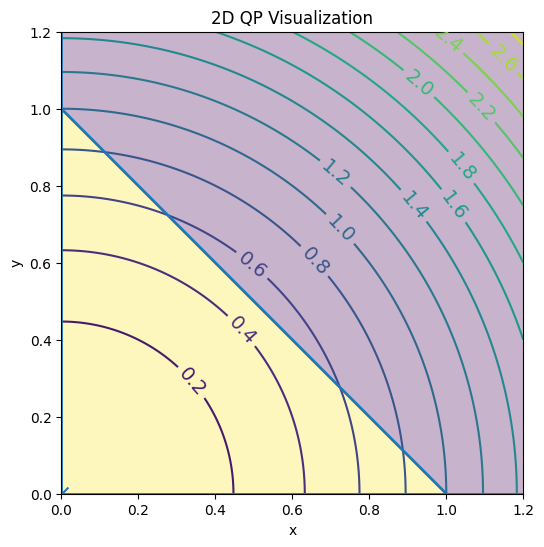

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Create a 2D grid for contour plot
x = np.linspace(0, 1.2, 400)
y = np.linspace(0, 1.2, 400)
X, Y = np.meshgrid(x, y)
Z = X**2 + Y**2  # Quadratic objective

# Define linear constraints: x + y <= 1, x >= 0, y >= 0
# Create mask for feasible region
feasible = (X + Y <= 1) & (X >= 0) & (Y >= 0)

# Find optimal point (should be at (0,0) unconstrained, but here inside region best is (0,0))
# Actually constrained minimum on region: unconstrained min at (0,0) which is feasible.
opt_x, opt_y = 0, 0

# Plot
plt.figure(figsize=(6, 6))
# Contours for objective
cs = plt.contour(X, Y, Z, levels=15)
plt.clabel(cs, inline=1, fontsize=14)

# Shade feasible region
plt.imshow(feasible.astype(int), extent=(x.min(), x.max(), y.min(), y.max()),
           origin='lower', alpha=0.3, interpolation='nearest')

# Plot constraint boundary lines
plt.plot(x, 1 - x, linewidth=2)  # x + y = 1
plt.axvline(0, linewidth=2)      # x = 0
plt.axhline(0, linewidth=2)      # y = 0

# Plot optimal point
plt.scatter(opt_x, opt_y, marker='x', s=100)

# Labels and title
plt.title("2D QP Visualization")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0, 1.2)
plt.ylim(0, 1.2)
plt.grid(False)
plt.show()


In [52]:
def split_points_by_class(vertex_array, vertex_object_ids, class_index):
    mask = vertex_object_ids == class_index
    points_in_class = vertex_array[mask]
    points_not_in_class = vertex_array[~mask]
    return points_in_class, points_not_in_class, ~mask

# # room_0
# # 72 - chair, 73 - cushion, 25 - floor, 60 - rug
# classes = [[73, 72], [25, 60]]

# # office_3
# # 87 - floor
# classes = [[87]]

# office_4
# 87 - floor
classes = [[7]]

class_pts = {}
out_masks = []
for class_grp in classes:
    print(class_grp)
    pts = []
    for class_idx in class_grp:
        print(class_idx)
        points_in, points_out, out_mask = split_points_by_class(vertex_array, vertex_object_ids, class_idx)
        out_masks.append(out_mask)
        pts.append(points_in)

    # class_pts.append(np.vstack(pts))
    cname = class_mapping.get(class_grp[0], "unknown")
    class_pts[cname] = np.vstack(pts)

    print(f"{class_pts[cname].shape[0]} points in class {class_idx}")
    print(f"{points_out.shape[0]} points outside class {class_idx}")

out_mask = np.logical_and.reduce(out_masks)
class_pts['room'] = vertex_array[out_mask]

# plot = k3d.plot()
# for i, (cname, points_in) in enumerate(class_pts.items()):
#     print(cname, points_in.shape)
#     plot += k3d.points(positions=points_in, color=(0x0000FF + i * 367), point_size=0.01)

# plot += k3d.points(positions=points_out, color=0xFF0000, point_size=0.01)
# plot.display()

[7]
7
191381 points in class 7
801627 points outside class 7


In [53]:
import numpy as np
from sklearn.decomposition import PCA

def calculate_bounds(points):
    x_min, x_max = np.min(points[:, 0]), np.max(points[:, 0])
    y_min, y_max = np.min(points[:, 1]), np.max(points[:, 1])
    z_min, z_max = np.min(points[:, 2]), np.max(points[:, 2])
    
    return np.array([[x_min, x_max], [y_min, y_max], [z_min, z_max]]), (np.array([x_min, y_min, z_min]), np.array([x_max, y_max, z_max]))


def get_upper_xy_plane_points(point_cloud, bbox_min, bbox_max, z_tol=1e-3):
    z_max = bbox_max[2]
    mask = np.abs(point_cloud[:, 2] - z_max) < z_tol
    return mask

def downsample_random_indices(points, K):
    indices = np.random.choice(points.shape[0], K, replace=False)
    return indices

_, bbox = calculate_bounds(class_pts['room'])
roof_mask = get_upper_xy_plane_points(class_pts['room'], bbox[0], bbox[1], z_tol = 0.5)
class_pts['roof'] = class_pts['room'][roof_mask]
class_pts['room'] = class_pts['room'][~roof_mask]

In [54]:
# Plot with point cloud
plot = k3d.plot()
for i, (cname, pts) in enumerate(class_pts.items()):
    plot += k3d.points(pts, point_size=0.01, color=(0x0000FF + i * 177))
# plot += k3d.points(roof, point_size=0.05, color=0x00FF00)
plot.display()

Output()

In [55]:
def average_nearest_neighbor_distance(points):
    tree = cKDTree(points)
    distances, _ = tree.query(points, k=2)
    nn_distances = distances[:, 1]
    return np.mean(nn_distances), np.std(nn_distances)

def remove_outliers(point_cloud, method="statistical", nb_neighbors=25, std_ratio=1.5, radius=0.1, min_neighbors=5, ret_indices=False):
    # Convert to Open3D point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(point_cloud)

    if method == "statistical":
        # Statistical Outlier Removal (SOR)
        clean_pcd, inlier_indices = pcd.remove_statistical_outlier(nb_neighbors=nb_neighbors, std_ratio=std_ratio)
    elif method == "radius":
        # Radius Outlier Removal (ROR)
        clean_pcd, inlier_indices = pcd.remove_radius_outlier(nb_points=min_neighbors, radius=radius)
    else:
        raise ValueError("Invalid method. Use 'statistical' or 'radius'.")

    if ret_indices:
        return np.asarray(clean_pcd.points), np.asarray(inlier_indices)

    return np.asarray(clean_pcd.points)

def filtered_point_cloud_indices(A, B, min_distance=0.1):
    tree = cKDTree(A)
    distances, _ = tree.query(B)
    return distances > min_distance

def sample_states_and_controls_timed(inner_point_cloud, point_cloud, N, K, min_dot=0.25):
    def sample_vector():
        vec = np.random.randn(3)
        return vec / np.linalg.norm(vec)

    idx = np.random.choice(point_cloud.shape[0], N, replace=False)
    sampled_points = point_cloud[idx]
    kdtree = cKDTree(inner_point_cloud)
    distances, nearest_indices = kdtree.query(sampled_points, k=2)
    nearest_neighbors = inner_point_cloud[nearest_indices[:, 1]]
    sampled_data = []

    for i in range(N):
        x, y, z = sampled_points[i]
        uc = nearest_neighbors[i] - sampled_points[i]
        uc = uc / np.linalg.norm(uc)
        sampled_data.append([x, y, z, uc[0], uc[1], uc[2]])
        for _ in range(K - 1):
            random_vector = sample_vector()
            while np.dot(random_vector, uc) < min_dot:
                random_vector = -random_vector
                if np.dot(random_vector, uc) < min_dot:
                    random_vector = sample_vector()
            sampled_data.append([x, y, z, random_vector[0], random_vector[1], random_vector[2]])

    return np.array(sampled_data)

def compute_interface_normals(interface_filtered, normal_radius, max_nn):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(interface_filtered)
    pcd.estimate_normals(
        search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=normal_radius, max_nn=max_nn)
    )
    pcd.normalize_normals()
    normals = np.asarray(pcd.normals)
    print("Interface / Normals", interface_filtered.shape, normals.shape)
    return normals

def compute_pts_on_env(domain_filtered, all_outers_filtered, interface_density, pts_on_env_thickness):
    ao_env = all_outers_filtered[
        filtered_point_cloud_indices(domain_filtered, all_outers_filtered, interface_density)
    ]
    pts_on_env = ao_env[
        ~filtered_point_cloud_indices(domain_filtered, ao_env, pts_on_env_thickness)
    ]
    print("Done with pts_on_env", pts_on_env.shape)
    return pts_on_env

def compute_outer_points(domain_filtered, all_outers_filtered, outer_density):
    outers = all_outers_filtered[
        filtered_point_cloud_indices(domain_filtered, all_outers_filtered, outer_density)
    ]
    print("Done with outers/envelope", outers.shape)
    return outers

In [71]:
def orient_normals_outward(points, normals) -> torch.Tensor:
    centroid = points.mean(axis=0)  # (3,)
    direction_to_centroid = centroid - points  # shape (N, 3)

    dot_products = np.sum(normals * direction_to_centroid, axis=1)  # shape (N,)
    flip_mask = dot_products > 0
    normals[flip_mask] = -normals[flip_mask]

    return normals

augemented_points = []
for cname, points in class_pts.items():
    inner_std_n = 1.5
    pts_on_env_thickness = 0.025
    interface_thickness=0.025
    inner_thickness=0.05
    normal_radius=0.05
    max_nn=30

    # if cname != "floor": continue
    print(cname, points.shape)
    indices = downsample_random_indices(points, min(points.shape[0], 600_000))
    points = np.ascontiguousarray(points, dtype=np.float64)
    points = points[indices]

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.estimate_normals(
        search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=normal_radius, max_nn=max_nn)
    )
    pcd.normalize_normals()
    normals = np.asarray(pcd.normals)
    # normals = orient_normals_outward(points, normals)

    outer_extras = []
    bounds, bounds_box = calculate_bounds(points)
    widths = bounds[:, 1] - bounds[:, 0]  # [x_width, y_width, z_width]
    outer_extras_thickness = np.max(widths)
    for step in np.linspace(1e-2, outer_extras_thickness, 30):
        sampled_indices = downsample_random_indices(points, min(points.shape[0], 20_000))
        points_tmp = points[sampled_indices]
        normals_tmp = normals[sampled_indices]
        
        outer_extras.append(points_tmp + normals_tmp  * step)
        outer_extras.append(points_tmp - normals_tmp  * step)
    envelope = np.vstack(outer_extras)

    inners = []
    for step in np.linspace(1e-2, inner_thickness, 10):
        inners.append(points + normals * step)
        inners.append(points - normals * step)

    domain = np.vstack(inners)  # And the opposite direction
    inner_m, inner_std = average_nearest_neighbor_distance(domain)
    inner_density = inner_m + inner_std * inner_std_n

    interface_thickness = inner_thickness + interface_thickness
    outers = []
    for step in np.linspace(inner_thickness + 1e-2, interface_thickness + inner_density, 2):
        outers.append(points + normals  * step)
        outers.append(points - normals  * step)
    interface_filtered = np.vstack(outers)
    normals_filtered = np.vstack([normals] * len(outers))
    print("Done with interface_filtered", interface_filtered.shape)
    print("normals_filteredd", normals_filtered.shape)

    pts_on_env_thickness = interface_thickness + pts_on_env_thickness
    pts_on_envs = []
    for step in np.linspace(interface_thickness + inner_density + 1e-2, pts_on_env_thickness + inner_density, 2):
        pts_on_envs.append(points + normals  * step)
        pts_on_envs.append(points - normals  * step)
    pts_on_env_filtered = np.vstack(pts_on_envs)
    print("Done with pts_on_env_filtered", pts_on_env_filtered.shape)

    min_neighbors = 8

    # inner layer
    domain_filtered = domain[downsample_random_indices(domain, min(points.shape[0] * 5, 500_000))]
    domain_filtered = remove_outliers(domain_filtered, radius=inner_density, min_neighbors=min_neighbors)
    inner_m, inner_std = average_nearest_neighbor_distance(domain_filtered)
    inner_density = inner_m + inner_std * inner_std_n + 0.05
    print("Done with inner layer", domain_filtered.shape)

    # all points
    bbox_offset = 0.5
    n_all_outers = min(points.shape[0] * 10, 1_000_000)
    bounds, bounds_box = calculate_bounds(domain_filtered)
    expanded_bounds = bounds_box[0] - bbox_offset, bounds_box[1] + bbox_offset
    all_outers = np.random.uniform(low=expanded_bounds[0], high=expanded_bounds[1], size=(n_all_outers, 3))
    print("Done with all points", all_outers.shape)

    # interface
    interface_thickness = inner_density + interface_thickness
    all_outers_filtered = all_outers[
        filtered_point_cloud_indices(domain_filtered, all_outers, inner_density)
    ]
    # interface_filtered = all_outers_filtered[
    #     ~filtered_point_cloud_indices(domain_filtered, all_outers_filtered, interface_thickness)
    # ]
    # print("Done with interface", interface_filtered.shape)

    # Prepare variables for parallel work
    interface_density = interface_thickness + inner_density
    # pts_on_env_thickness = interface_density + pts_on_env_thickness
    outer_density = pts_on_env_thickness + inner_density

    # Run them in parallel
    with ThreadPoolExecutor() as executor:
        futures = [
            # executor.submit(compute_interface_normals, interface_filtered, normal_radius, max_nn),
            # executor.submit(compute_pts_on_env, domain_filtered, all_outers_filtered, interface_density, pts_on_env_thickness),
            executor.submit(compute_outer_points, domain_filtered, all_outers_filtered, pts_on_env_thickness)
        ]
        envelope_filtered = [f.result() for f in futures][0]

    # control
    N = 2000
    K = 40
    control_outs_env = sample_states_and_controls_timed(domain_filtered, envelope_filtered, N // 3, K)
    control_outs_on_env = sample_states_and_controls_timed(domain_filtered, pts_on_env_filtered, N // 3, K)
    control_outs_interface = sample_states_and_controls_timed(domain_filtered, interface_filtered, N // 3, K)
    control_outs = np.vstack([control_outs_env, control_outs_interface, control_outs_on_env])
    control_points, controls = control_outs[:, :3], control_outs[:, 3:]
    print("Done with control", control_points.shape)

    # bounds, scaling, translation
    all_points = np.vstack([domain, interface_filtered, pts_on_env_filtered, envelope_filtered])
    bounds_og, bounds_coords = calculate_bounds(all_points)
    bbox_min, bbox_max = bounds_coords
    bounds = bounds_og.copy()

    all_points_obj = np.vstack([domain, interface_filtered])
    bounds_obj, _ = calculate_bounds(all_points_obj)

    center_for_translation = (bbox_max + bbox_min) / 2
    scale_factor = max(bbox_max - bbox_min) / 2

    print("Done with bounds, scaling, translation:", bounds_coords, scale_factor, center_for_translation)

    augemented_points.append({
        "class": cname,
        "pts_inside": domain_filtered,
        "env_outside_pts": envelope_filtered,
        "pts_on_env": pts_on_env_filtered,
        "outside_points": envelope_filtered,
        "control_points": control_outs,
        "control_points_on_env": control_outs_on_env,
        "control_points_env": control_outs_env,
        "control_points_interface": control_outs_interface,
        "original": points,
        "interface_pts": interface_filtered,
        "interface_normals": normals_filtered,
        "bounds": bounds,
        "bounds_obj": bounds_obj,
        "scale_factor": scale_factor,
        "center_for_translation": center_for_translation
    })


floor (191381, 3)
Done with interface_filtered (765524, 3)
normals_filteredd (765524, 3)
Done with pts_on_env_filtered (765524, 3)
Done with inner layer (463203, 3)
Done with all points (1000000, 3)
Done with outers/envelope (837730, 3)
Done with control (79920, 3)
Done with bounds, scaling, translation: (array([-1.69264729, -2.82388553, -1.75918988]), array([ 5.8419531 ,  4.67733011, -0.60321323])) 3.7673001949681186 [ 2.07465291  0.92672229 -1.18120156]
room (546066, 3)
Done with interface_filtered (2184264, 3)
normals_filteredd (2184264, 3)
Done with pts_on_env_filtered (2184264, 3)
Done with inner layer (473938, 3)
Done with all points (1000000, 3)
Done with outers/envelope (872316, 3)
Done with control (79920, 3)
Done with bounds, scaling, translation: (array([-1.74682637, -2.87487475, -1.72013876]), array([5.88576913, 4.72721917, 1.61043957])) 3.816297750651868 [ 2.06947138  0.92617221 -0.0548496 ]
roof (255561, 3)
Done with interface_filtered (1022244, 3)
normals_filteredd (1022

In [35]:
import k3d
import numpy as np
import random

plot = k3d.plot()

colors = {
    "original": 0xff0000,             # Red
    # "pts_inside": 0x00ff00,           # Green
    # "interface_pts": 0x0000ff,        # Blue
    # "env_outside_pts": 0xffff00,      # Yellow
    # "pts_on_env": 0xff00ff,           # Magenta
    # "outside_points": 0x00ffff,       # Cyan
    # "control_points": 0x808080,       # Gray
    # "control_points_on_env": 0xFFA500,# Orange
    # "control_points_env": 0x800080,   # Purple
    # "control_points_interface": 0x008000 # Dark Green
}

# print(domain.shape, domain_normals.shape)
# # plot += k3d.vectors(domain[:domain_normals.shape[0]], domain_normals, color=0x0000ff, head_size=0.1)  # Blue
# print(interface_filtered.shape, normals_filtered.shape)
# plot += k3d.vectors(interface_filtered, normals_filtered / 10, color=0xFFA500, head_size=0.25, line_width=0.001)  # Blue
# plot += k3d.points(interface_tmp, point_size=0.01, color=0x808080)
# plot += k3d.points(pts_on_env_tmp, point_size=0.01, color=0x008000)

# plot += k3d.points(bounds_obj.T, point_size=0.05, color=0x008000)
plot.display()
for i, data_dict in enumerate(augemented_points):
    print(f"\nPlotting object {i}: {data_dict.get('class', 'Unknown')}")
    # if data_dict.get('class', 'Unknown') != 'room':
    #     continue
    
    for key, value in data_dict.items():
        if not isinstance(value, np.ndarray):
            continue
        
        if value.ndim == 2 and value.shape[1] >= 3:
            pts = value[:, :3]
            col = colors.get(key, -1)
            if col != -1:
                plot += k3d.points(pts, point_size=0.01, color=col)
                print(f"{key} bounds: min {pts.min(axis=0)}, max {pts.max(axis=0)}")
                print("ADDED", key, pts.shape)

# plot += k3d.points(interface_tmp_big, point_size=0.01, color=0x008000)

Output()

NameError: name 'augemented_points' is not defined

In [73]:
# import shutil

# name = room_name + "_objects"
# out_path = os.path.join(
#     "/scratch/rhm4nj/cral/cral-ginn/ginn/myvis/data_gen", 
#     "replica",
#     name
# )
# print("Saving to:", out_path)

# if not os.path.exists(out_path):
#     os.makedirs(out_path)
# else:
#     shutil.rmtree(out_path)

# skips_names = []

# for idx, values in enumerate(augemented_points):
#     folder_name = f"{idx}_{values['class']}"
#     folder_path = os.path.join(out_path, folder_name)
#     os.makedirs(folder_path)

#     for name, arrays in values.items():
#         if name in skips_names: continue

#         print(f'Saving to {folder_name}:', name)
#         np.save(f'{folder_path}/{name}.npy', arrays)